In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from pypapi import events, papi_high as high
%matplotlib inline


Classification of age groups using functional connectivity
==========================================================

This example compares different kinds of functional connectivity between
regions of interest : correlation, partial correlation, and tangent space
embedding.

The resulting connectivity coefficients can be used to
discriminate children from adults. In general, the tangent space embedding
**outperforms** the standard correlations: see `Dadi et al 2019
<https://www.sciencedirect.com/science/article/pii/S1053811919301594>`_
for a careful study.


Load brain development fMRI dataset and MSDL atlas
-------------------------------------------------------------------
We study only 30 subjects from the dataset, to save computation time.



In [2]:
from nilearn import datasets

development_dataset = datasets.fetch_development_fmri(n_subjects=30)

We use probabilistic regions of interest (ROIs) from the MSDL atlas.



In [3]:
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
print('MSDL has {0} ROIs, part of the following networks :\n{1}.'.format(
    n_regions, msdl_data.networks))

MSDL has 39 ROIs, part of the following networks :
[b'Aud', b'Aud', b'Striate', b'DMN', b'DMN', b'DMN', b'DMN', b'Occ post', b'Motor', b'R V Att', b'R V Att', b'R V Att', b'R V Att', b'Basal', b'L V Att', b'L V Att', b'L V Att', b'D Att', b'D Att', b'Vis Sec', b'Vis Sec', b'Vis Sec', b'Salience', b'Salience', b'Salience', b'Temporal', b'Temporal', b'Language', b'Language', b'Language', b'Language', b'Language', b'Cereb', b'Dors PCC', b'Cing-Ins', b'Cing-Ins', b'Cing-Ins', b'Ant IPS', b'Ant IPS'].


Region signals extraction
-------------------------
To extract regions time series, we instantiate a
:class:`nilearn.input_data.NiftiMapsMasker` object and pass the atlas the
file name to it, as well as filtering band-width and detrending option.



In [4]:
from nilearn import input_data

masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1).fit()

Then we compute region signals and extract useful phenotypic informations.



In [5]:
children = []
pooled_subjects = []
groups = []  # child or adult
for func_file, confound_file, phenotypic in zip(
        development_dataset.func,
        development_dataset.confounds,
        development_dataset.phenotypic):
    time_series = masker.transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    if phenotypic['Child_Adult'] == 'child':
        children.append(time_series)
    groups.append(phenotypic['Child_Adult'])

print('Data has {0} children.'.format(len(children)))

Data has 24 children.


ROI-to-ROI correlations of children
-----------------------------------
The simpler and most commonly used kind of connectivity is correlation. It
models the full (marginal) connectivity between pairwise ROIs. We can
estimate it using :class:`nilearn.connectome.ConnectivityMeasure`.

From the list of ROIs time-series for children, the
`correlation_measure` computes individual correlation matrices.



In [8]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(children)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of children are stacked in an array of shape {0}'
      .format(correlation_matrices.shape))
      

Correlations of children are stacked in an array of shape (24, 39, 39)


In [9]:
mean_correlation_matrix = correlation_measure.mean_
print('Mean correlation has shape {0}.'.format(mean_correlation_matrix.shape))

Mean correlation has shape (39, 39).


We display the connectome matrices of the first 3 children



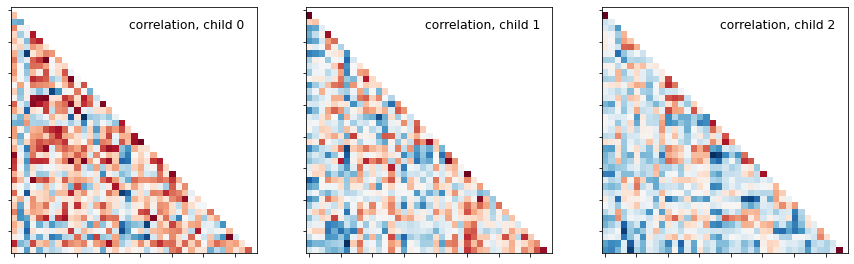

In [10]:
from nilearn import plotting
from matplotlib import pyplot as plt

_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(correlation_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax,
                         title='correlation, child {}'.format(i))

The blocks structure that reflect functional networks are visible.



Now we display as a connectome the mean correlation matrix over all children.



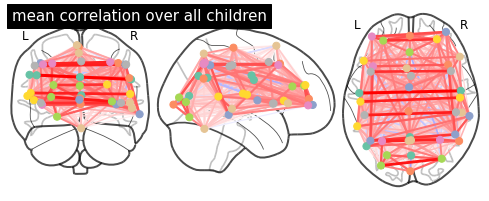

In [11]:
plotting.plot_connectome(mean_correlation_matrix, msdl_coords,
                         title='mean correlation over all children')

Studying partial correlations
-----------------------------
We can also study **direct connections**, revealed by partial correlation
coefficients. We just change the `ConnectivityMeasure` kind



In [12]:
partial_correlation_measure = ConnectivityMeasure(kind='partial correlation')
partial_correlation_matrices = partial_correlation_measure.fit_transform(
    children)


Most of direct connections are weaker than full connections.



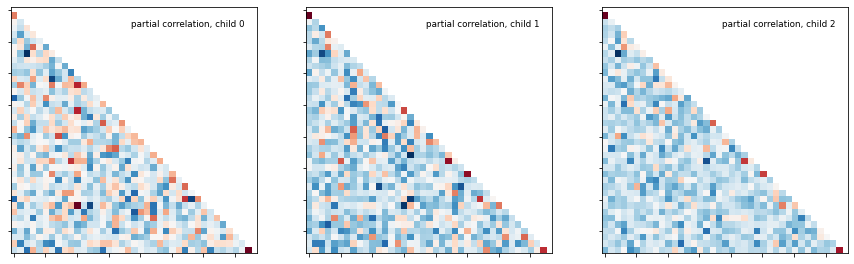

In [13]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(partial_correlation_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax,
                         title='partial correlation, child {}'.format(i))

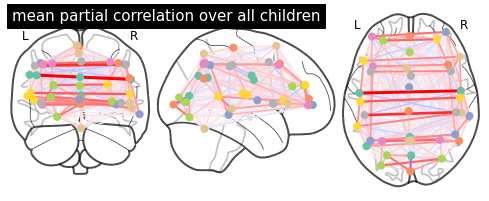

In [14]:
plotting.plot_connectome(
    partial_correlation_measure.mean_, msdl_coords,
    title='mean partial correlation over all children')

Extract subjects variabilities around a group connectivity
----------------------------------------------------------
We can use **both** correlations and partial correlations to capture
reproducible connectivity patterns at the group-level.
This is done by the tangent space embedding.

We fit our children group and get the group connectivity matrix stored as
in `tangent_measure.mean_`, and individual deviation matrices of each subject
from it.




In [15]:
tangent_measure = ConnectivityMeasure(kind='tangent')
tangent_matrices = tangent_measure.fit_transform(children)

`tangent_matrices` model individual connectivities as
**perturbations** of the group connectivity matrix `tangent_measure.mean_`.
Keep in mind that these subjects-to-group variability matrices do not
directly reflect individual brain connections. For instance negative
coefficients can not be interpreted as anticorrelated regions.



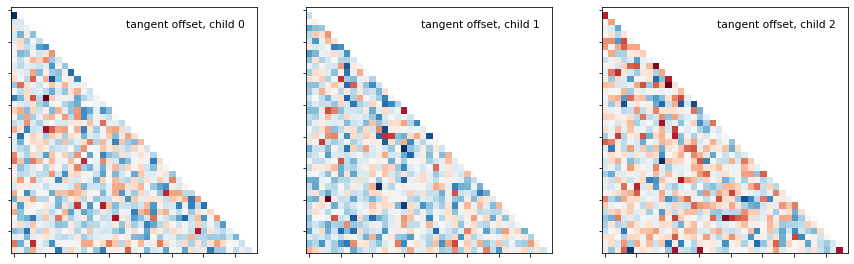

In [16]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(tangent_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax,
                         title='tangent offset, child {}'.format(i))

The average tangent matrix cannot be interpreted, as individual matrices
represent deviations from the mean, which is set to 0.



What kind of connectivity is most powerful for classification?
--------------------------------------------------------------
We will use connectivity matrices as features to distinguish children from
adults. We use cross-validation and measure classification accuracy to
compare the different kinds of connectivity matrices.
We use random splits of the subjects into training/testing sets.
StratifiedShuffleSplit allows preserving the proportion of children in the
test set.



In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import numpy as np

kinds = ['correlation', 'partial correlation', 'tangent']
model_list = [LogisticRegression(),LinearSVC(),RandomForestClassifier(),]
_, classes = np.unique(groups, return_inverse=True)
cv = StratifiedShuffleSplit(n_splits=15, random_state=0, test_size=5)
pooled_subjects = np.asarray(pooled_subjects)

FLOP_type_dict = {'SP':events.PAPI_SP_OPS, 'DP':events.PAPI_DP_OPS}
FLOP_conter_df = pd.DataFrame(columns=['brain_feature','task','iter','model','FLOP_type','FLOP_count','perf'])

scores = {}
i = 0
for kind in kinds:
    scores[kind] = []
    for ml_model in model_list:
        cv_split = 0 
        for train, test in cv.split(pooled_subjects, classes):

            # *ConnectivityMeasure* can output the estimated subjects coefficients
            # as a 1D arrays through the parameter *vectorize*.
            # OPs counters
            for FLOP_name, FLOP_type in FLOP_type_dict.items():
                high.start_counters([FLOP_type,])
                
                connectivity = ConnectivityMeasure(kind=kind, vectorize=True)
                # build vectorized connectomes for subjects in the train set
                connectomes = connectivity.fit_transform(pooled_subjects[train])

                OPS_count = high.stop_counters()[0]

                FLOP_conter_df.loc[i] = [kind,'feature_selection',cv_split,ml_model,FLOP_name,OPS_count,None]
                i = i + 1
            
            # fit the classifier
            # OPs counter
            for FLOP_name, FLOP_type in FLOP_type_dict.items():
                high.start_counters([FLOP_type,])        
                classifier = ml_model.fit(connectomes, classes[train])
                OPS_count = high.stop_counters()[0]

                FLOP_conter_df.loc[i] = [kind,'train',cv_split,ml_model,FLOP_name,OPS_count,None]
                i = i + 1

            # make predictions for the left-out test subjects
            for FLOP_name, FLOP_type in FLOP_type_dict.items():
                high.start_counters([FLOP_type,])
                predictions = classifier.predict(
                    connectivity.transform(pooled_subjects[test]))
                OPS_count = high.stop_counters()[0]

                # store the accuracy for this cross-validation fold
                acc = accuracy_score(classes[test], predictions)
                scores[kind].append(acc)

                FLOP_conter_df.loc[i] = [kind,'test',cv_split,ml_model,FLOP_name,OPS_count,acc]
                i = i + 1

display the results



This is a small example to showcase nilearn features. In practice such
comparisons need to be performed on much larger cohorts and several
datasets.
`Dadi et al 2019
<https://www.sciencedirect.com/science/article/pii/S1053811919301594>`_
Showed that across many cohorts and clinical questions, the tangent
kind should be preferred.



In [25]:
FLOP_conter_df.head()

,brain_feature,task,iter,model,FLOP_type,FLOP_count,perf
0,correlation,feature_selection,0,LogisticRegression(),SP,0,NaN
1,correlation,feature_selection,0,LogisticRegression(),DP,8242543,NaN
2,correlation,train,0,LogisticRegression(),SP,0,NaN
3,correlation,train,0,LogisticRegression(),DP,4514734,NaN
4,correlation,test,0,LogisticRegression(),SP,0,0.8


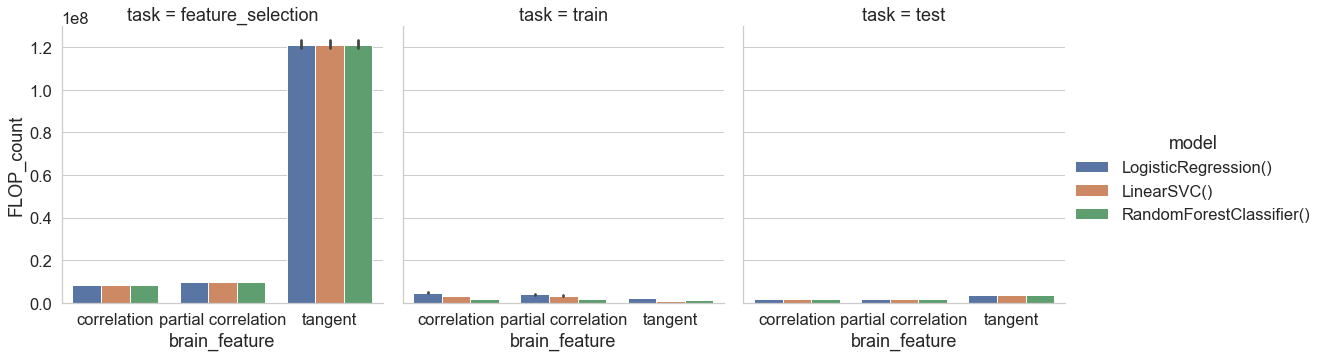

In [37]:
plot_df = FLOP_conter_df[FLOP_conter_df['FLOP_type'] == 'DP'].copy()
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='FLOP_count',x='brain_feature',hue='model',col='task',
    data=plot_df,kind='bar')
    # g.set(yscale="log") 
    

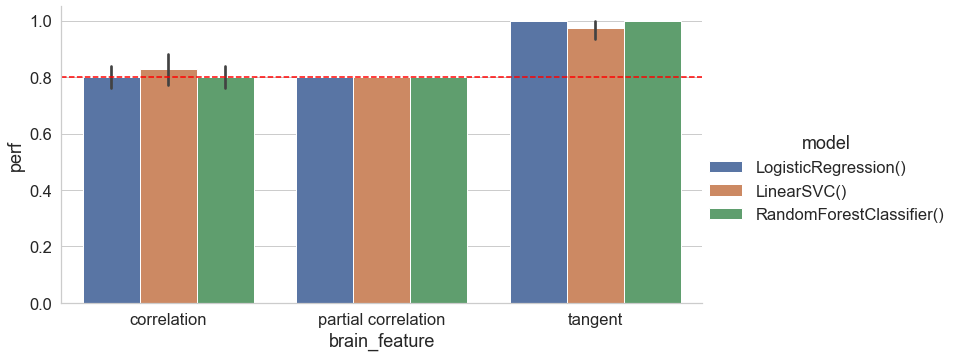

In [39]:
plot_df = FLOP_conter_df[(FLOP_conter_df['FLOP_type'] == 'DP') & (FLOP_conter_df['task'] == 'test')].copy()
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='brain_feature',y='perf',hue='model',
    data=plot_df,kind='bar',aspect=2)
    plt.gca().axhline(.8, color='red', linestyle='--')